# Can a strength in one lift make you better overall?

## Aims:
This is a small project where I will aim to classify lifters based on the ratio each lift takes out of their total (i.e. based on squat/total, bench/total and deadlift/total). 

I will then use this to determine if there is one lift that makes you a 'better' lifter (by specialising in this given lift).

I decided to use the data from the 2025 IPF World Classic Powerlifting Championships - https://www.openpowerlifting.org/m/ipf/2503.

This is because with only ~400 entries, it’s easier to see distinct clusters, and using top-level athletes means that, for example, a lower bench ratio may reflect biomechanics (e.g., long arms), whereas at amateur meets, a lower bench ratio may just be down to poor training (so amateur data will skew results). High-level athletes must perform well across all lifts, so their ratios better reveal clearer patterns.

In [1]:
import numpy as np
import pandas as pd

fulldata = pd.read_csv('data/ipf_2503.csv')

## Data Preprocessing

There is limited preprocessing needed since this is a well-maintained dataset. I will first select the following columns: Name, Sex, WeightClassKg, Best3SquatKg, Best3BenchKg, Best3DeadliftKg, TotalKg, and Dots. 

Dots is a formula used to compare lifters across sexes and weight classes (i.e. to make sure the 'best' lifter isn't the one with the highest total, otherwise this will just be the winner of the heaviest male weight class).

I want to explore whether being stronger in a particular lift makes an athlete more likely to have a higher dots number.

In [3]:
# Select relevant columns
selected_columns = [
    'Name', 'Sex', 'WeightClassKg',
    'Best3SquatKg', 'Best3BenchKg', 'Best3DeadliftKg',
    'TotalKg', 'Dots'
]

data = fulldata[selected_columns].copy()

data.dropna(inplace=True)   # a couple of lifters got disqualified and have no totals.
data.drop(index=7, inplace=True)
data.drop(index=8, inplace=True)
data.drop(index=78, inplace=True)
data.drop(index=99, inplace=True)  # these lifters are all ceremonial and are not the focus of the analysis.

There is not much data preprocessing beyond this. It may make sense to represent Sex or WeightClassKg (currently a string) numerically but this data will not be given to the algorithm, I just want it for later to see if patterns in sex or weight classes emerge.

## Feature engineering

Again, feature engineering is simple since we only need to calculate each ratio for the lifters.

In [4]:
data['SquatRatio'] = data['Best3SquatKg'] / data['TotalKg']
data['BenchRatio'] = data['Best3BenchKg'] / data['TotalKg']
data['DeadliftRatio'] = data['Best3DeadliftKg'] / data['TotalKg']

subdata = data[['SquatRatio', 'BenchRatio', 'DeadliftRatio']].copy()

## Model Implementation
This is my first ever attempt at using a clustering algorithm so I am learning as I go. From my understanding, I try out a different number of clusters to find the right balance between underfitting and overfitting.

In [7]:
from sklearn.cluster import KMeans

kmeans3 = KMeans(n_clusters=3, random_state=0)
kmeans3.fit(subdata)

data['Cluster3'] = kmeans3.labels_

In [8]:
import plotly.express as px

data['Cluster3'] = data['Cluster3'].astype(str)

fig = px.scatter_3d(
    subdata,
    x='SquatRatio',
    y='BenchRatio',
    z='DeadliftRatio',
    color=data['Cluster3'],
    opacity=0.8,
    labels={'color': 'Cluster'}
)

fig.show()

Trying for a different number of clusters.

In [11]:
kmeans4 = KMeans(n_clusters=4, random_state=0)
kmeans4.fit(subdata)

data['Cluster4'] = kmeans4.labels_

data['Cluster4'] = data['Cluster4'].astype(str)

fig = px.scatter_3d(
    subdata,
    x='SquatRatio',
    y='BenchRatio',
    z='DeadliftRatio',
    color=data['Cluster4'],
    opacity=0.8,
    labels={'color': 'Cluster'}
)

fig.show()

I don't think 4 clusters works well for this purpose though, it would cluster the lifters as good at either squat, bench or deadlift, or just being good at all three (the fourth cluster) and I imagine this fourth cluster would tend to always have the highest dots total on average, although I will test this hypothesis later.

In [12]:
kmeans5 = KMeans(n_clusters=5, random_state=0)
kmeans5.fit(subdata)

data['Cluster5'] = kmeans5.labels_

data['Cluster5'] = data['Cluster5'].astype(str)

fig = px.scatter_3d(
    subdata,
    x='SquatRatio',
    y='BenchRatio',
    z='DeadliftRatio',
    color=data['Cluster5'],
    opacity=0.8,
    labels={'color': 'Cluster'}
)

fig.show()

# Analysis
A sensible next step from here is to draw a boxplot of each cluster to see how they compare.

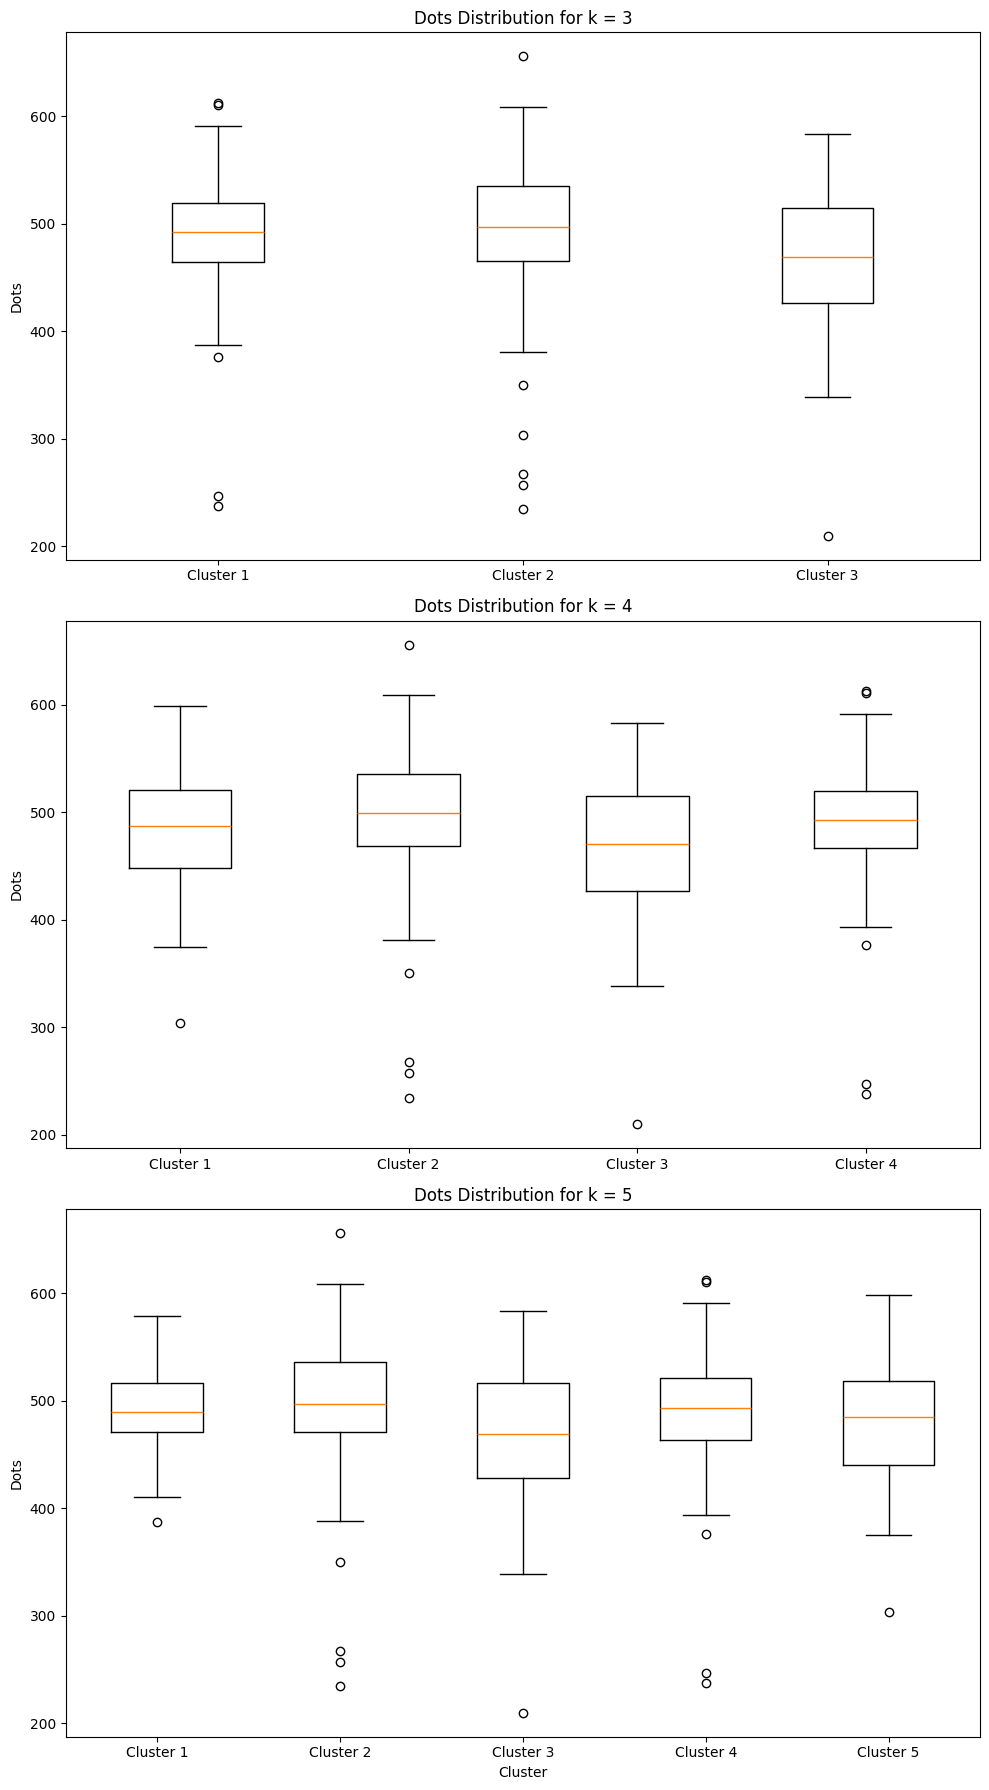

In [17]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 1, figsize=(10, 18))

# 3 clusters
axes[0].boxplot(
    [data[data['Cluster3'] == str(i)]['Dots'] for i in range(3)],
    tick_labels=[f'Cluster {i+1}' for i in range(3)]
)
axes[0].set_title('Dots Distribution for k = 3')
axes[0].set_ylabel('Dots')

# 4 clusters
axes[1].boxplot(
    [data[data['Cluster4'] == str(i)]['Dots'] for i in range(4)],
    tick_labels=[f'Cluster {i+1}' for i in range(4)]
)
axes[1].set_title('Dots Distribution for k = 4')
axes[1].set_ylabel('Dots')

# 5 clusters
axes[2].boxplot(
    [data[data['Cluster5'] == str(i)]['Dots'] for i in range(5)],
    tick_labels=[f'Cluster {i+1}' for i in range(5)]
)
axes[2].set_title('Dots Distribution for k = 5')
axes[2].set_ylabel('Dots')
axes[2].set_xlabel('Cluster')

plt.tight_layout()
plt.show()